In [1]:
# Import dependencies
import pandas as pd
import numpy as np
import seaborn as sns

# Plot confusion matrices
import matplotlib as mpl 
import matplotlib.cm as cm 
import matplotlib.pyplot as plt

# NLP libraries
import re
import string
import unicodedata
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words_nltk = set(stopwords.words('english'))
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()

# Machine learning
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

# Evaluate the classifiers
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix 

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Boss\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Boss\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Connect to database

In [2]:
# SQL Alchemy
from sqlalchemy import create_engine

In [3]:
# Create engine and connection
engine = create_engine("sqlite:///../db.sqlite")

In [4]:
# Check for tables
engine.table_names()

['cuisine_ingredients']

In [5]:
# Read in the data table
df = pd.read_sql_query('SELECT * FROM cuisine_ingredients', con=engine)

In [6]:
# Overview of the data set
df.sample(10, random_state=2)

,id,cuisine,recipe,full_ingredients
3727,3728,Italian,Spicy fregola with scallops and crispy kale,"['olive oil, for shallow and deep frying', '1 ..."
1923,1924,Chinese,Chunky bacon and cucumber salad,"['1 tbsp groundnut oil', '6 long dried chillie..."
3552,3553,Italian,Polenta pork,"['2 tbsp sunflower oil ', '12 rashers thick ri..."
1146,1147,British,Oat fig stuffing,"['140g/5oz butter', '100g/3½oz jumbo oats', '1..."
3195,3196,Italian,Bolognese with tagliatelle,"['250g/9oz 00 flour', '3-4 medium free-range e..."
1643,1644,British,Textured potato salad,"['675g/1½lb floury potatoes, peeled and cut in..."
3054,3055,Indian,Tandoori lamb wrap,"['150ml/5fl oz Greek-style yoghurt ', '½ small..."
842,843,British,Gammon and pease pudding,"['300g/10oz dried yellow split peas', '50g/2oz..."
505,506,British,Braised shin of beef with parsnip purée,"['4kg/9lb beef shin, on the bone', 'sea salt a..."
2224,2225,French,Mary Berry's celeriac remoulade,"['650g/1lb 7oz celeriac, peeled and sliced int..."


In [7]:
# Get a list of unique cuisines in the dataset
cuisine_list = df.cuisine.unique().tolist()
cuisine_list

['African',
 'American',
 'British',
 'Caribbean',
 'Chinese',
 'East European',
 'French',
 'Greek',
 'Indian',
 'Irish',
 'Italian',
 'Japanese',
 'Korean',
 'Mexican',
 'Nordic',
 'North African',
 'Pakistani',
 'Portuguese',
 'South American',
 'Spanish',
 'Thai and South-East Asian',
 'Turkish and Middle Eastern']

## Define text pre-processing function

In [8]:
# Create a function to remove accented characters
def remove_accented_chars(matchobj):
    text = matchobj.group()
    new_text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return new_text

In [9]:
words_to_remove = [
    "tbsp", "roughly", "chopped", "tsp", "finely", "oz", "plus", "optional",
    "extra", "fresh", "freshly", "ground", "thinly", "sliced", "clove", "pint",
    "cut", "kg", "lb", "cm", "ml", "mm", "small", "large", "medium", "diced", "slice",
    "pinch", "peeled", "grated", "removed", "handful", "piece", "crushed", "red", "dried",
    "drained", "rinsed", "halved", "trimmed", "deseeded", "x", "beaten", "available", "supermarket"]

In [10]:
# Create a function to clean ingredient text
def clean(doc):
    doc = doc.str.lower()
    doc = doc.str.replace(r'\w*[\d¼½¾⅓⅔⅛⅜⅝]\w*', '')
    doc = doc.str.translate(str.maketrans('', '', string.punctuation))
    doc = doc.str.replace(r'[£×–‘’“”⁄]', '')
    doc = doc.apply(lambda x: re.sub(r'[âãäçèéêîïñóôûüōưấớ]', remove_accented_chars, x))
    doc = doc.apply(lambda x: word_tokenize(x))
    doc = doc.apply(lambda x: [word for word in x if not word in stop_words_nltk])
    doc = doc.apply(lambda x: [word for word in x if not word in words_to_remove])
    doc = doc.apply(lambda x: [stemmer.stem(word) for word in x])
    processed_doc = doc.apply(lambda x: ' '.join([word for word in x]))

    return processed_doc

In [11]:
# Add a new column to the dataframe with the cleaned text
df["ingredients_processed"] = clean(df.full_ingredients)

In [12]:
# Overview of the dataset
df.sample(10, random_state=2)

,id,cuisine,recipe,full_ingredients,ingredients_processed
3727,3728,Italian,Spicy fregola with scallops and crispy kale,"['olive oil, for shallow and deep frying', '1 ...",oliv oil shallow deep fri shallot garlic chill...
1923,1924,Chinese,Chunky bacon and cucumber salad,"['1 tbsp groundnut oil', '6 long dried chillie...",groundnut oil long chilli sichuan peppercorn w...
3552,3553,Italian,Polenta pork,"['2 tbsp sunflower oil ', '12 rashers thick ri...",sunflow oil rasher thick rindless smoke streak...
1146,1147,British,Oat fig stuffing,"['140g/5oz butter', '100g/3½oz jumbo oats', '1...",butter jumbo oat roll oat onion pistachio fig ...
3195,3196,Italian,Bolognese with tagliatelle,"['250g/9oz 00 flour', '3-4 medium free-range e...",flour freerang egg prefer bright yellow yolk f...
1643,1644,British,Textured potato salad,"['675g/1½lb floury potatoes, peeled and cut in...",flouri potato cube rasher smoke streaki bacon ...
3054,3055,Indian,Tandoori lamb wrap,"['150ml/5fl oz Greek-style yoghurt ', '½ small...",greekstyl yoghurt onion garlic ginger garam ma...
842,843,British,Gammon and pease pudding,"['300g/10oz dried yellow split peas', '50g/2oz...",yellow split pea butter onion thyme bay leaf s...
505,506,British,Braised shin of beef with parsnip purée,"['4kg/9lb beef shin, on the bone', 'sea salt a...",beef shin bone sea salt black pepper oliv oil ...
2224,2225,French,Mary Berry's celeriac remoulade,"['650g/1lb 7oz celeriac, peeled and sliced int...",celeriac thin matchstick see tip lemon juic li...


## Modeling

### Split the data into training and test sets (75% train, 25% test)

In [13]:
# The column contains textual data to extract features from.
X = df.ingredients_processed

# The column we're learning to predict.
y = df.cuisine 
print(X.shape, y.shape)

(4724,) (4724,)


In [14]:
# Split X and y into training and testing sets. By default, it splits 75% training and 25% test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(3543,) (3543,)
(1181,) (1181,)


### Feature engineering using TF-IDF

In bag of words and bag of n-grams approaches, all words in a corpus are treated equally important. TF-IDF, meanwhile, emphasizes that some words in a document are more important than others. I'll firstly try TF-IDF with uni-grams.

In [15]:
tfidf = TfidfVectorizer()

In [16]:
# Vectorize train and test data
X_train_transformed = tfidf.fit_transform(X_train)
X_test_transformed = tfidf.transform(X_test)
print(X_train_transformed.shape, X_test_transformed.shape)

(3543, 2925) (1181, 2925)


### Train the model

In [17]:
# Instantiate a Multinomial Naive Bayes model
model = MultinomialNB()

# Train the model
%time model.fit(X_train_transformed, y_train)

Wall time: 34 ms


MultinomialNB()

In [18]:
# Make class predictions for X_test_transformed
y_predicted = model.predict(X_test_transformed)

### Evaluatae the model

In [19]:
# Print accuracy:
print("Accuracy: ", accuracy_score(y_test, y_predicted))

Accuracy:  0.5520745131244708


In [20]:
# Function to plot confusion matrix. 
# Ref: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
import itertools
from sklearn.metrics import roc_auc_score

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize=15)
    plt.xlabel('Predicted label',fontsize=15)

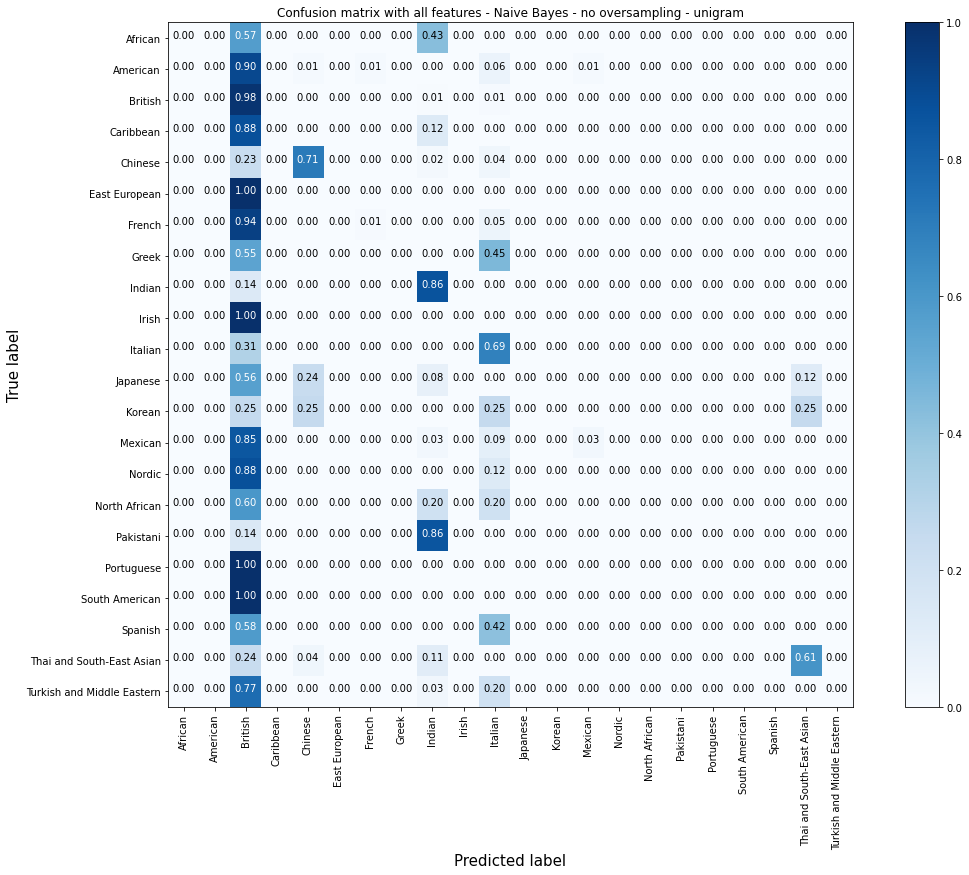

In [21]:
# print the confusion matrix
cnf_matrix = confusion_matrix(y_test, y_predicted)
plt.figure(figsize=(16, 12))
plot_confusion_matrix(cnf_matrix, classes=cuisine_list, normalize=True,
                      title='Confusion matrix with all features - Naive Bayes - no oversampling - unigram')
plt.savefig("../static/images/cfm_nb.png", bbox_inches='tight')

As expected, due to the dataset imbalance, most recipes are predicted as British cuisines.

In [22]:
# Calculate classification report
from sklearn.metrics import classification_report

print(classification_report(y_test, y_predicted,
                            target_names=cuisine_list))

                            precision    recall  f1-score   support

                   African       0.00      0.00      0.00         7
                  American       0.00      0.00      0.00        83
                   British       0.45      0.98      0.62       365
                 Caribbean       0.00      0.00      0.00        16
                   Chinese       0.79      0.71      0.75        52
             East European       0.00      0.00      0.00        16
                    French       0.50      0.01      0.02       110
                     Greek       0.00      0.00      0.00        22
                    Indian       0.74      0.86      0.80        88
                     Irish       0.00      0.00      0.00         5
                   Italian       0.74      0.69      0.71       211
                  Japanese       0.00      0.00      0.00        25
                    Korean       0.00      0.00      0.00         4
                   Mexican       0.50      0.03

C:\Users\Boss\anaconda3\envs\PythonAdv\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
